### 1.1 Настройка вспомогательных элементов

#### 1.1.1 Настройка библиотек

In [1]:
import os

# ГЛАВНЫЕ БИБЛИОТЕКИ ДЛЯ ОПТИМИЗИРОВАННОЙ РАБОТЫ С ДАННЫМИ - разряженные матрицы
import scipy.sparse as sp

# Для обработки таблиц и работы с массивами
import re
import numpy as np
import pandas as pd
import openpyxl
import json

# Загрузка Оптюны
import optuna

# Для расчёта метрики и разбивки выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт моделей
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Прочие библиотеки
import time
import math

import warnings
warnings.filterwarnings('ignore')

#### 1.1.2 Настройка директорий

In [2]:
this_directory = os.getcwd()

data_new = this_directory.split('notebooks')[0] + 'data'

dipl_directory = this_directory.split('main_folder')[0]

# В WIN подключение к данным выглядит так:
main_directory = this_directory.split('DiplomaToExport')[0]
data_directory = main_directory + 'raw_data'

xlsx_directory = data_directory + '\\excel\\'
dcsv_directory = data_directory + '\\csv\\'

# Создаем директорию для сохранения моделей и логов
os.makedirs(data_new + '\\model_logs', exist_ok=True)
data_logs = data_new + '\\model_logs\\'

In [3]:
print(data_logs)

c:\Users\pront\Desktop\Projects Python\University\Diploma\DiplomaToExport\main_folder\data\model_logs\


#### 1.1.3 Выгрузка данных

In [4]:
file_path = dcsv_directory + 'merge_TOTAL.csv'


# Функция для загрузки данных по частям
def load_data_in_chunks(file_path, chunk_size=10000):
    # Сначала определим количество строк и колонок для предварительного создания массивов
    total_rows = 0
    for chunk in pd.read_csv(file_path, chunksize=1):
        # Получаем имена колонок из первого чанка
        columns = chunk.columns
        break
    
    # Подсчитываем общее количество строк
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        total_rows += len(chunk)
    
    # Загружаем данные по частям и преобразуем в разреженные матрицы
    chunks = []
    y_values = []
    
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
        print(f"Обработка чанка {i+1}...")
        
        # Предобработка
        if 'ЖК рус' in chunk.columns:
            chunk = chunk.drop(columns=['ЖК рус'])
        chunk = chunk.fillna(0).astype(float)
        
        # Пробуем убрать нулевые значения цен
        chunk = chunk[chunk['Цена кв.м'] > 0]
        
        # Разделение на признаки и целевую переменную
        if 'Цена кв.м' in chunk.columns:
            y_chunk = chunk['Цена кв.м'].values
            X_chunk = chunk.drop('Цена кв.м', axis=1)
        else:
            raise ValueError("В данных отсутствует столбец 'Цена кв.м'")
        
        # Преобразование в разреженную матрицу
        chunks.append(sp.csr_matrix(X_chunk.values))
        y_values.extend(y_chunk)
    
    # Объединяем все чанки
    X_sparse = sp.vstack(chunks)
    y = np.array(y_values)
    
    return X_sparse, y


# Загрузка данных
X_sparse, y = load_data_in_chunks(file_path, chunk_size=50000)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# Словарь для хранения времени обучения и логов
training_times = {}
training_logs = {}

Обработка чанка 1...
Обработка чанка 2...
Обработка чанка 3...
Обработка чанка 4...
Обработка чанка 5...
Обработка чанка 6...
Обработка чанка 7...
Обработка чанка 8...
Обработка чанка 9...
Обработка чанка 10...
Обработка чанка 11...
Обработка чанка 12...
Обработка чанка 13...
Обработка чанка 14...
Обработка чанка 15...
Обработка чанка 16...
Обработка чанка 17...
Обработка чанка 18...
Обработка чанка 19...
Обработка чанка 20...
Обработка чанка 21...


### 2.1 Предобработка для моделей

#### 2.1.1 Настройка функций расчёта метрик и добавочных элементов к графикам

In [5]:
# Функция для расчета RMSE вручную
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

# Функция для расчета MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Избегаем деления на ноль
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Проверка доступности GPU
def check_gpu():
    try:
        # Проверка CUDA для XGBoost
        print(f"XGBoost CUDA доступен: {xgb.config.build_info()['USE_CUDA']}")
    except:
        print("Не удалось проверить XGBoost CUDA")
    
    try:
        # Проверка для CatBoost
        print(f"CatBoost поддерживаемые устройства: {cb.get_devices()}")
    except:
        print("Не удалось проверить CatBoost устройства")

# Функция для добавления статистики на график
def add_stats_to_plot(ax, y_true, y_pred, title, color):
    rmse = calculate_rmse(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    stats_text = f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nMAPE: {mape:.2f}%\nR²: {r2:.4f}'
    
    # Добавление текстового блока со статистикой
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    ax.set_title(title, fontsize=18, pad=20)
    
    # Добавление линии регрессии
    sns.regplot(x=y_true, y=y_pred, ax=ax, scatter=False, 
                line_kws={'color': color, 'alpha': 0.7, 'lw': 2})


Отдельна проверка для доступности GPU и настройка стиля для графиков

In [6]:
# Проверка GPU
print("Проверка доступности GPU...")
check_gpu()

# Настройка стиля Seaborn
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = [18, 10]
plt.rcParams['font.family'] = 'DejaVu Sans'
colors = sns.color_palette("viridis", 3)

catboost_color = colors[0]
xgboost_color = colors[1]
lightgbm_color = colors[2]

Проверка доступности GPU...
Не удалось проверить XGBoost CUDA
Не удалось проверить CatBoost устройства


### 2.2 Выгрузка моделей

---

#### 2.2.1 Выгрузка предобученной модели CatBoost

In [7]:
# Загрузка модели CatBoost из .cbm файла
cbm_path = data_logs + 'catboost_model.cbm'
catboost_model = cb.CatBoostRegressor(task_type='GPU')  # Использование GPU
catboost_model.load_model(cbm_path)

In [8]:
# Обучение моделей с лучшими параметрами
print("Обучение CatBoost на GPU...")
# Создаем новую модель CatBoost для обучения, так как мы уже загрузили существующую
catboost_train_model = cb.CatBoostRegressor(
                                            iterations=500,
                                            learning_rate=0.1,
                                            depth=6,
                                            loss_function='RMSE',
                                            task_type='GPU',
                                            devices='0'
                                            )

start_time = time.time()
catboost_train_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
training_times['CatBoost'] = time.time() - start_time
print(f"CatBoost обучен за {training_times['CatBoost']:.2f} секунд")


Обучение CatBoost на GPU...
CatBoost обучен за 5.56 секунд


---

In [9]:
# Класс для сохранения логов XGBoost
class XGBoostCallback:
    def __init__(self):
        self.logs = {'iteration': [], 'train_rmse': [], 'val_rmse': []}
    
    def __call__(self, env):
        iteration = env.iteration
        train_rmse = env.evaluation_result_list[0][1]
        val_rmse = env.evaluation_result_list[1][1]
        
        self.logs['iteration'].append(iteration)
        self.logs['train_rmse'].append(train_rmse)
        self.logs['val_rmse'].append(val_rmse)

# Класс для сохранения логов LightGBM
class LGBMCallback:
    def __init__(self):
        self.logs = {'iteration': [], 'train_rmse': [], 'val_rmse': []}
    
    def __call__(self, env):
        iteration = env.iteration
        train_rmse = env.evaluation_result_list[0][2]
        val_rmse = env.evaluation_result_list[1][2]
        
        self.logs['iteration'].append(iteration)
        self.logs['train_rmse'].append(train_rmse)
        self.logs['val_rmse'].append(val_rmse)
        return False

#### 2.2.2 Выгрузка предобученной модели XGBoost

In [10]:
best_params_xgb = json.loads(open(data_logs + 'best_params_xgb.json').read())

In [11]:
print("Обучение XGBoost с оптимальными параметрами на GPU...")
# Добавляем параметры GPU к лучшим параметрам
best_params_xgb.update({
                        'tree_method': 'gpu_hist',
                        'gpu_id': 0
                        })
xgb_model = xgb.XGBRegressor(**best_params_xgb)
start_time = time.time()

# Создаем колбэк для сохранения логов XGBoost
xgb_callback = XGBoostCallback()

# Правильный способ использования early_stopping в XGBoost с сохранением логов
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ['train', 'validation']
xgb_model.fit(
                X_train, y_train, 
                eval_set=eval_set,
                verbose=0
                )
training_times['XGBoost'] = time.time() - start_time
training_logs['XGBoost'] = xgb_callback.logs
print(f"XGBoost обучен за {training_times['XGBoost']:.2f} секунд")

Обучение XGBoost с оптимальными параметрами на GPU...
XGBoost обучен за 6.58 секунд


#### 2.2.3 Выгрузка предобученной модели LightGBM

In [12]:
best_params_lgb = json.loads(open(data_logs + 'best_params_lgb.json').read())

In [13]:
print("Обучение LightGBM с оптимальными параметрами на GPU...")

# Создаем колбэк для сохранения логов LightGBM
lgbm_callback = LGBMCallback()

# Создаем датасеты для LightGBM
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test, reference=dtrain)

# Добавляем колбэк для ранней остановки
early_stopping = lgb.early_stopping(stopping_rounds=50, verbose=False)
callbacks = [lgbm_callback, early_stopping]

# Преобразуем параметры для использования в train
lgb_train_params = {
                    'objective': 'regression',
                    'metric': 'rmse',
                    'boosting_type': 'gbdt',
                    'learning_rate': best_params_lgb['learning_rate'],
                    'num_leaves': best_params_lgb['num_leaves'],
                    'max_depth': best_params_lgb['max_depth'],
                    'subsample': best_params_lgb['subsample'],
                    'feature_fraction': best_params_lgb['feature_fraction'],
                    'lambda_l1': best_params_lgb['lambda_l1'],
                    'lambda_l2': best_params_lgb['lambda_l2'],
                    'min_data_in_leaf': best_params_lgb['min_data_in_leaf'],
                    'min_gain_to_split': best_params_lgb['min_gain_to_split'],
                    'device': 'gpu',
                    'gpu_platform_id': 0,
                    'gpu_device_id': 0,
                    'verbose': -1
                    }

# Обучаем модель с помощью низкоуровневого API
start_time = time.time()
lgb_booster = lgb.train(
                        params=lgb_train_params,
                        train_set=dtrain,
                        num_boost_round=best_params_lgb.get('num_round', 100),
                        valid_sets=[dtrain, dvalid],
                        valid_names=['train', 'valid'],
                        callbacks=callbacks
                        )
training_times['LightGBM'] = time.time() - start_time
training_logs['LightGBM'] = lgbm_callback.logs
print(f"LightGBM обучен за {training_times['LightGBM']:.2f} секунд")

Обучение LightGBM с оптимальными параметрами на GPU...
LightGBM обучен за 3.22 секунд


### 2.3 Результаты моделей

#### 2.3.1 Сравнение метрик моделей

In [14]:
# Получение предсказаний
# Используем загруженную модель CatBoost для предсказаний
start_time = time.time()
y_pred_catboost = catboost_model.predict(X_test)
prediction_times = {'CatBoost': time.time() - start_time}

start_time = time.time()
y_pred_xgb = xgb_model.predict(X_test)
prediction_times['XGBoost'] = time.time() - start_time

start_time = time.time()
y_pred_lgb = lgb_booster.predict(X_test)
prediction_times['LightGBM'] = time.time() - start_time

# Расчет метрик
rmse_catboost = calculate_rmse(y_test, y_pred_catboost)
rmse_xgb = calculate_rmse(y_test, y_pred_xgb)
rmse_lgb = calculate_rmse(y_test, y_pred_lgb)

r2_catboost = r2_score(y_test, y_pred_catboost)
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

mape_catboost = mean_absolute_percentage_error(y_test, y_pred_catboost)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)

# Создание DataFrame для метрик
metrics_df = pd.DataFrame({
                        'Модель': ['CatBoost', 'XGBoost', 'LightGBM'],
                        'RMSE': [rmse_catboost, rmse_xgb, rmse_lgb],
                        'MAE': [mae_catboost, mae_xgb, mae_lgb],
                        'MAPE (%)': [mape_catboost, mape_xgb, mape_lgb],
                        'R²': [r2_catboost, r2_xgb, r2_lgb],
                        'Время обучения (сек)': [training_times.get('CatBoost', 0), 
                                                training_times.get('XGBoost', 0), 
                                                training_times.get('LightGBM', 0)],
                        'Время предсказания (сек)': [prediction_times.get('CatBoost', 0), 
                                                prediction_times.get('XGBoost', 0), 
                                                prediction_times.get('LightGBM', 0)]
                        })
print(metrics_df)

     Модель          RMSE           MAE  MAPE (%)        R²  \
0  CatBoost  23151.902738  15665.528829  8.583994  0.944310   
1   XGBoost  15205.992427   9264.761658  4.868769  0.975977   
2  LightGBM  17977.529729  11678.340937  6.380309  0.966422   

   Время обучения (сек)  Время предсказания (сек)  
0              5.564033                  0.171402  
1              6.576437                  0.126176  
2              3.217445                  0.068777  


#### 2.3.2 Сводные графики по результатам моделей

In [15]:
# Создание DataFrame для визуализации
df_catboost = pd.DataFrame({'Реальные': y_test, 'Предсказанные': y_pred_catboost, 'Модель': 'CatBoost'})
df_xgb = pd.DataFrame({'Реальные': y_test, 'Предсказанные': y_pred_xgb, 'Модель': 'XGBoost'})
df_lgb = pd.DataFrame({'Реальные': y_test, 'Предсказанные': y_pred_lgb, 'Модель': 'LightGBM'})

# Объединение данных
df_all = pd.concat([df_catboost, df_xgb, df_lgb])

# Определение диапазона для линии идеального соответствия
min_val = min(np.min(y_test), np.min(y_pred_catboost), np.min(y_pred_xgb), np.min(y_pred_lgb))
max_val = max(np.max(y_test), np.max(y_pred_catboost), np.max(y_pred_xgb), np.max(y_pred_lgb))
line_vals = np.linspace(min_val, max_val, 100)

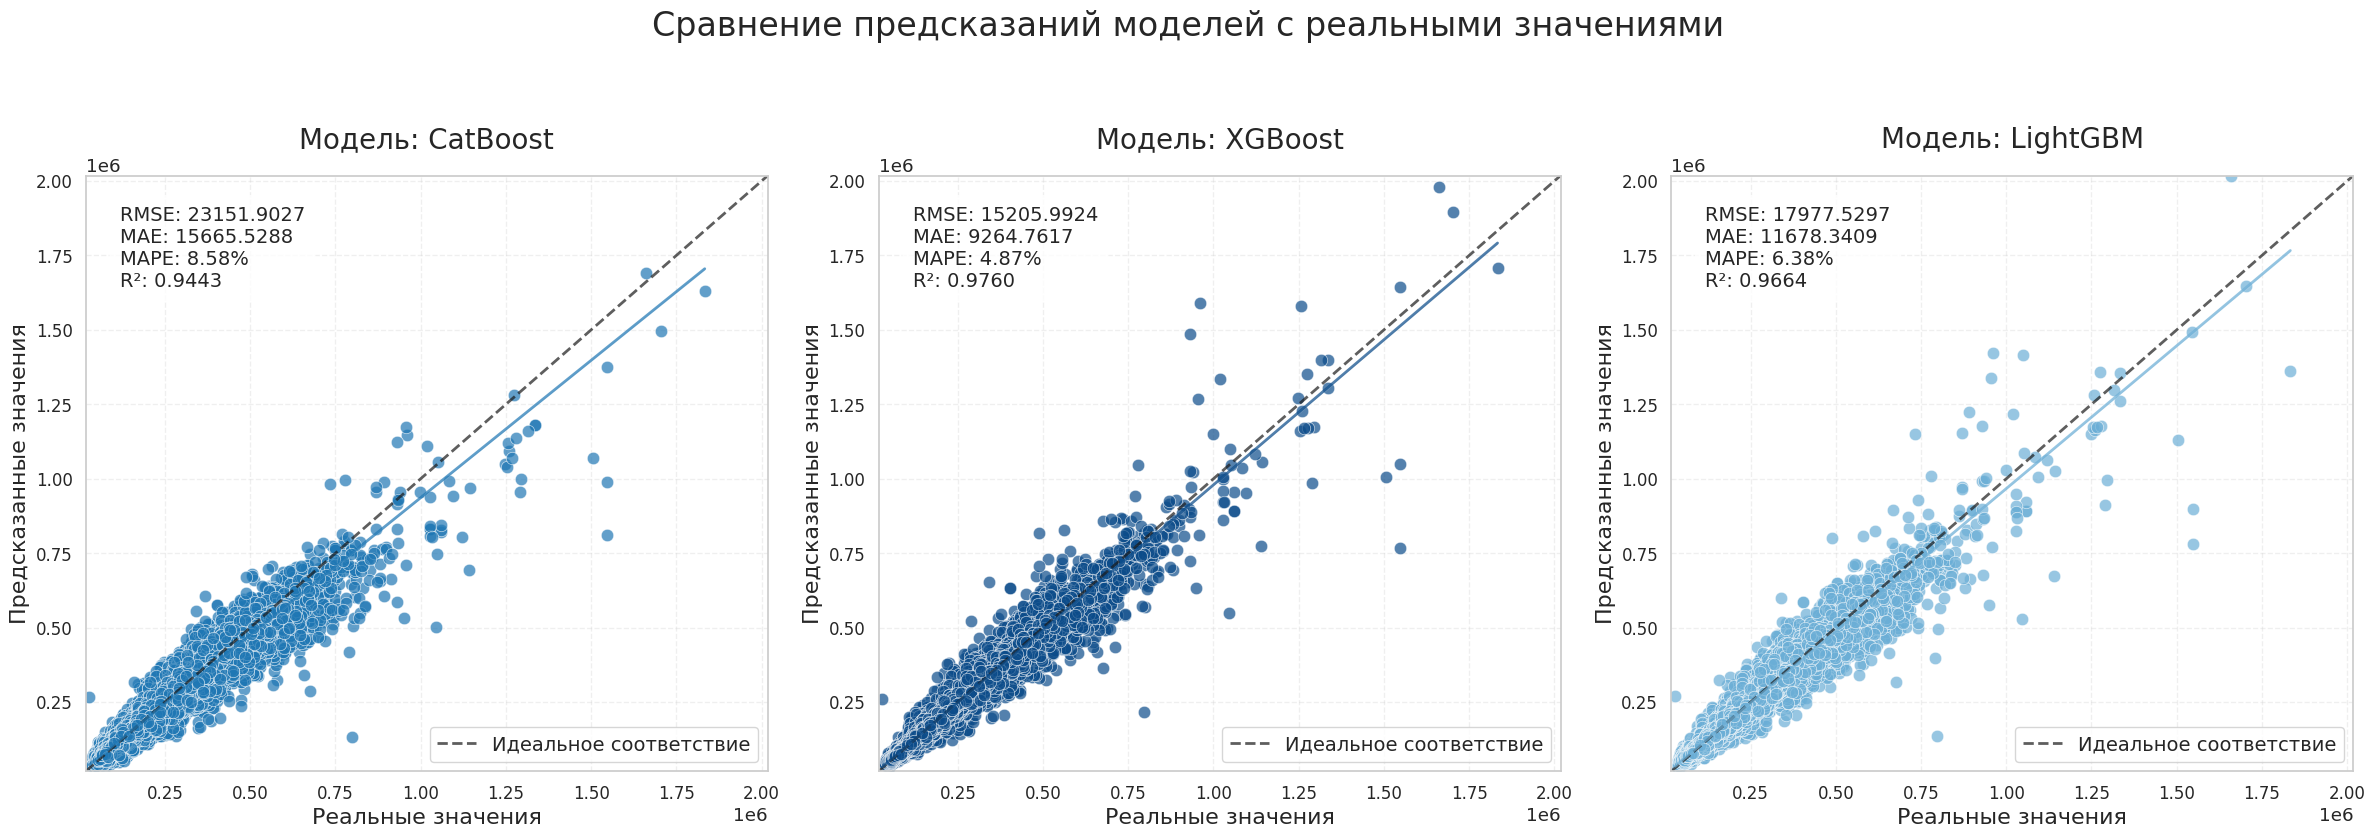

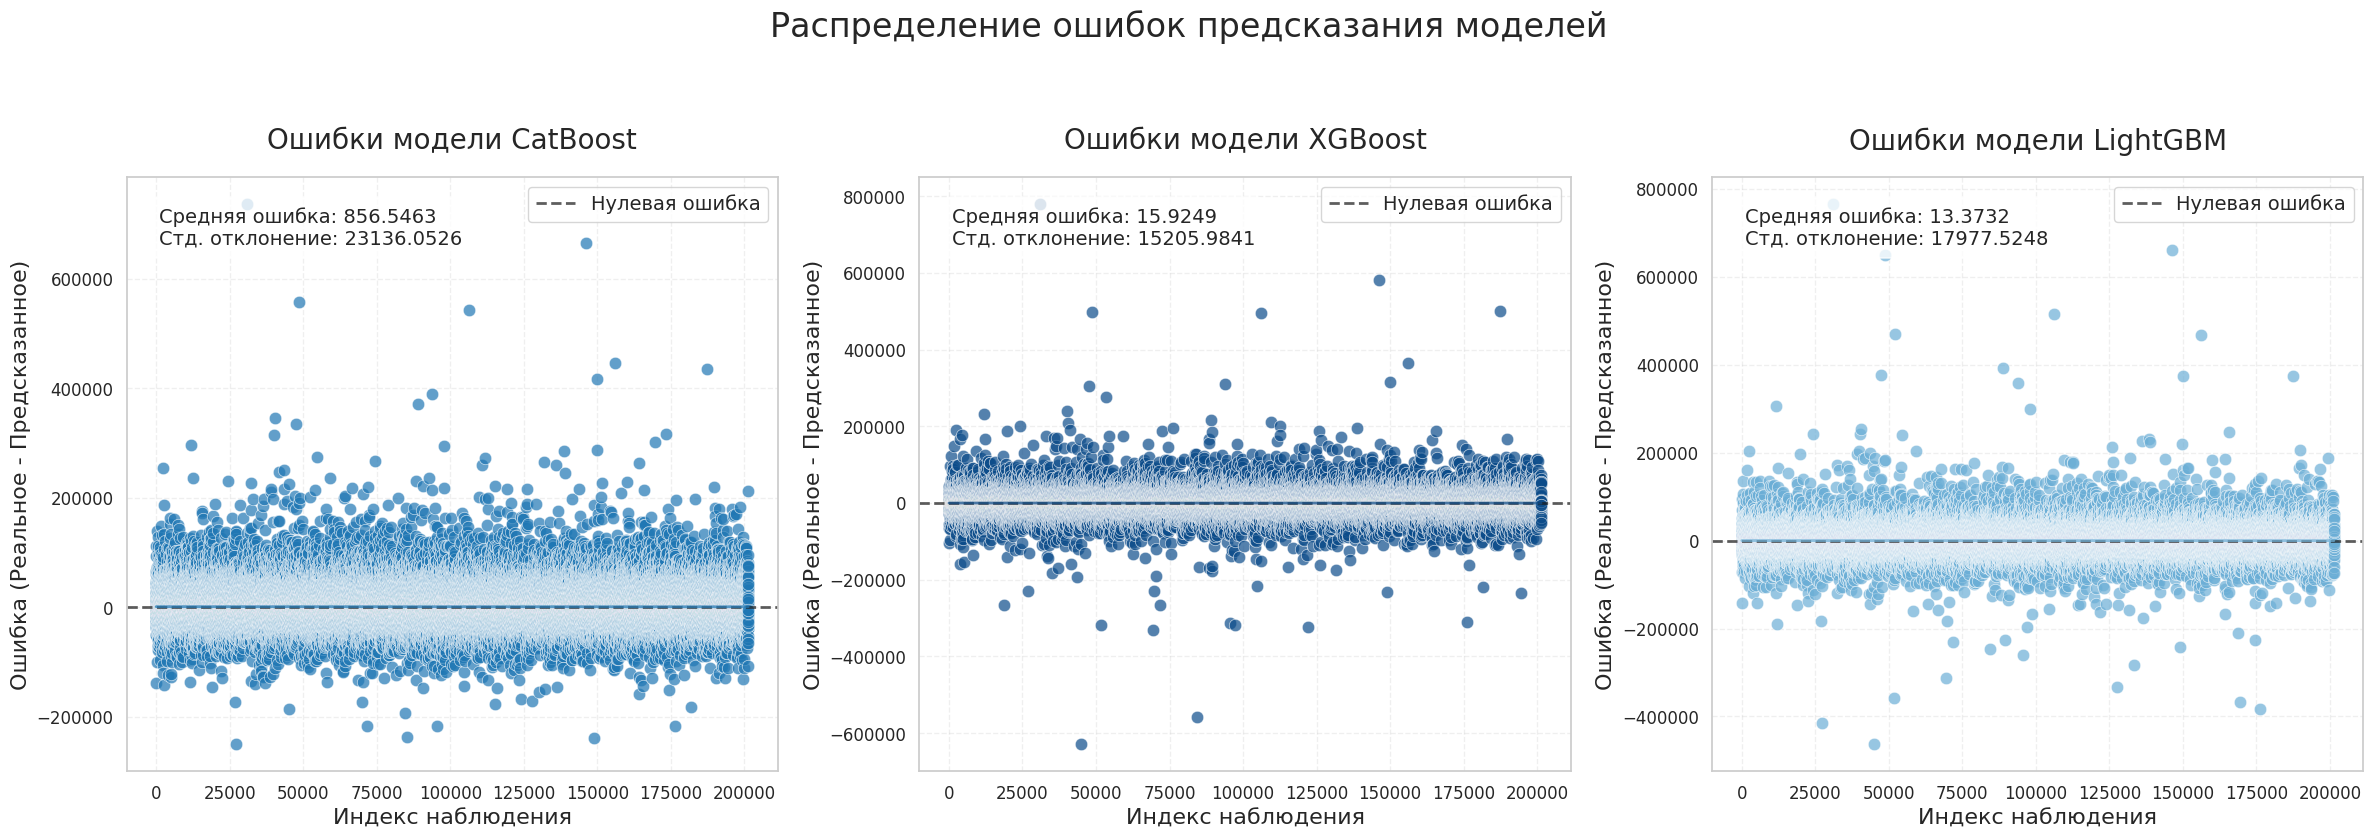

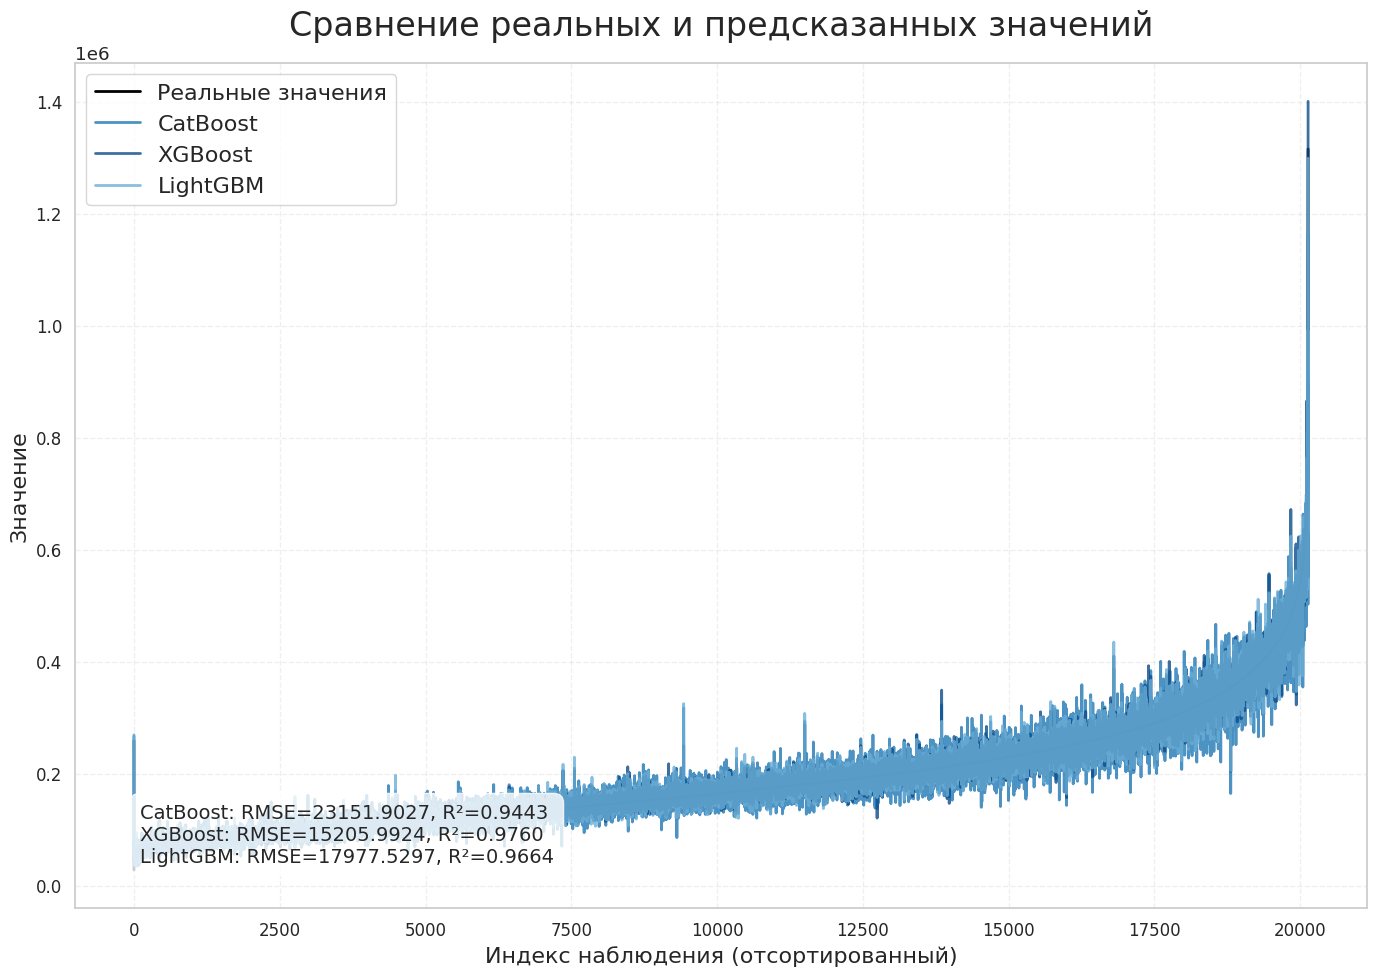

In [16]:
# Создание сводного графика для сравнения всех моделей

# Обновленная цветовая схема - голубо-синие оттенки
catboost_color = '#1f77b4'  # голубой
xgboost_color = '#0c4c8a'   # синий
lightgbm_color = '#6baed6'  # светло-голубой

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Сравнение предсказаний моделей с реальными значениями', fontsize=24, y=1.05)

# Общие настройки для всех графиков
models = ['CatBoost', 'XGBoost', 'LightGBM']
colors = [catboost_color, xgboost_color, lightgbm_color]
predictions = [y_pred_catboost, y_pred_xgb, y_pred_lgb]
rmse_values = [rmse_catboost, rmse_xgb, rmse_lgb]
mae_values = [mae_catboost, mae_xgb, mae_lgb]
mape_values = [mape_catboost, mape_xgb, mape_lgb]
r2_values = [r2_catboost, r2_xgb, r2_lgb]

# Определение диапазона для линии идеального соответствия
min_val = min(np.min(y_test), np.min(y_pred_catboost), np.min(y_pred_xgb), np.min(y_pred_lgb))
max_val = max(np.max(y_test), np.max(y_pred_catboost), np.max(y_pred_xgb), np.max(y_pred_lgb))
line_vals = np.linspace(min_val, max_val, 100)

# Создание графиков для каждой модели
for i, (model, color, y_pred, rmse, mae, mape, r2) in enumerate(zip(models, colors, predictions, rmse_values, mae_values, mape_values, r2_values)):
    
    # Создание scatterplot
    sns.scatterplot(
                    x=y_test,
                    y=y_pred,
                    ax=axes[i],
                    alpha=0.7,
                    color=color,
                    s=80,
                    edgecolor='w',
                    linewidth=0.5
                    )
    
    # Добавление линии идеального соответствия
    axes[i].plot(line_vals, line_vals, 'k--', linewidth=2, alpha=0.7, label='Идеальное соответствие')
    
    # Добавление линии регрессии
    sns.regplot(
                x=y_test, 
                y=y_pred, 
                ax=axes[i], 
                scatter=False, 
                line_kws={'color': color, 'alpha': 0.7, 'lw': 2, 'label': 'Линия регрессии'}
                )
    
    # Добавление текстового блока с метриками
    metrics_text = f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nMAPE: {mape:.2f}%\nR²: {r2:.4f}'
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
    
    # Настройка заголовка и осей
    axes[i].set_title(f'Модель: {model}', fontsize=20, pad=20)
    axes[i].set_xlabel('Реальные значения', fontsize=16)
    axes[i].set_ylabel('Предсказанные значения', fontsize=16)
    axes[i].tick_params(labelsize=12)
    
    # Настройка легенды
    axes[i].legend(fontsize=14)
    
    # Добавление сетки
    axes[i].grid(True, linestyle='--', alpha=0.3)
    
    # Установка одинаковых пределов для осей
    axes[i].set_xlim(min_val, max_val)
    axes[i].set_ylim(min_val, max_val)

plt.tight_layout()
plt.show()

# Дополнительно: создание графика с распределением ошибок предсказания (изменено на scatterplot)
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Распределение ошибок предсказания моделей', fontsize=24, y=1.05)

# Расчет ошибок предсказания
errors = [y_test - y_pred_catboost, y_test - y_pred_xgb, y_test - y_pred_lgb]

# Создание графиков распределения ошибок для каждой модели (scatterplot вместо гистограммы)
for i, (model, color, error) in enumerate(zip(models, colors, errors)):
    # Создание индексов для оси X
    indices = np.arange(len(error))
    
    # Создание scatterplot ошибок
    sns.scatterplot(
                    x=indices,
                    y=error,
                    ax=axes[i],
                    alpha=0.7,
                    color=color,
                    s=80,
                    edgecolor='w',
                    linewidth=0.5
                    )
    
    # Добавление горизонтальной линии в нуле (baseline)
    axes[i].axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='Нулевая ошибка')
    
    # Добавление линии тренда
    sns.regplot(
                x=indices, 
                y=error, 
                ax=axes[i], 
                scatter=False, 
                line_kws={'color': color, 'alpha': 0.7, 'lw': 2, 'label': 'Тренд ошибок'}
                )
    
    # Добавление статистики ошибок
    error_stats = f'Средняя ошибка: {np.mean(error):.4f}\nСтд. отклонение: {np.std(error):.4f}'
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    axes[i].text(0.05, 0.95, error_stats, transform=axes[i].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
    
    # Настройка заголовка и осей
    axes[i].set_title(f'Ошибки модели {model}', fontsize=20, pad=20)
    axes[i].set_xlabel('Индекс наблюдения', fontsize=16)
    axes[i].set_ylabel('Ошибка (Реальное - Предсказанное)', fontsize=16)
    axes[i].tick_params(labelsize=12)
    
    # Настройка легенды
    axes[i].legend(fontsize=14)
    
    # Добавление сетки
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительно: график сравнения реальных и предсказанных значений для всех моделей
plt.figure(figsize=(14, 10))
plt.title('Сравнение реальных и предсказанных значений', fontsize=24, pad=20)

# Создание линейного графика для визуализации тренда
# Сортируем данные по реальным значениям для лучшей визуализации
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
y_pred_catboost_sorted = y_pred_catboost[sorted_indices]
y_pred_xgb_sorted = y_pred_xgb[sorted_indices]
y_pred_lgb_sorted = y_pred_lgb[sorted_indices]

# Выбираем подмножество точек для лучшей визуализации (каждую 10-ю точку)
step = 10
plt.plot(y_test_sorted[::step], label='Реальные значения', color='black', linewidth=2)
plt.plot(y_pred_catboost_sorted[::step], label='CatBoost', color=catboost_color, linewidth=2, alpha=0.8)
plt.plot(y_pred_xgb_sorted[::step], label='XGBoost', color=xgboost_color, linewidth=2, alpha=0.8)
plt.plot(y_pred_lgb_sorted[::step], label='LightGBM', color=lightgbm_color, linewidth=2, alpha=0.8)

# Настройка осей и легенды
plt.xlabel('Индекс наблюдения (отсортированный)', fontsize=16)
plt.ylabel('Значение', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Добавление текстового блока с метриками
metrics_text = (
                f"CatBoost: RMSE={rmse_catboost:.4f}, R²={r2_catboost:.4f}\n"
                f"XGBoost: RMSE={rmse_xgb:.4f}, R²={r2_xgb:.4f}\n"
                f"LightGBM: RMSE={rmse_lgb:.4f}, R²={r2_lgb:.4f}"
                )
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
plt.text(0.05, 0.05, metrics_text, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


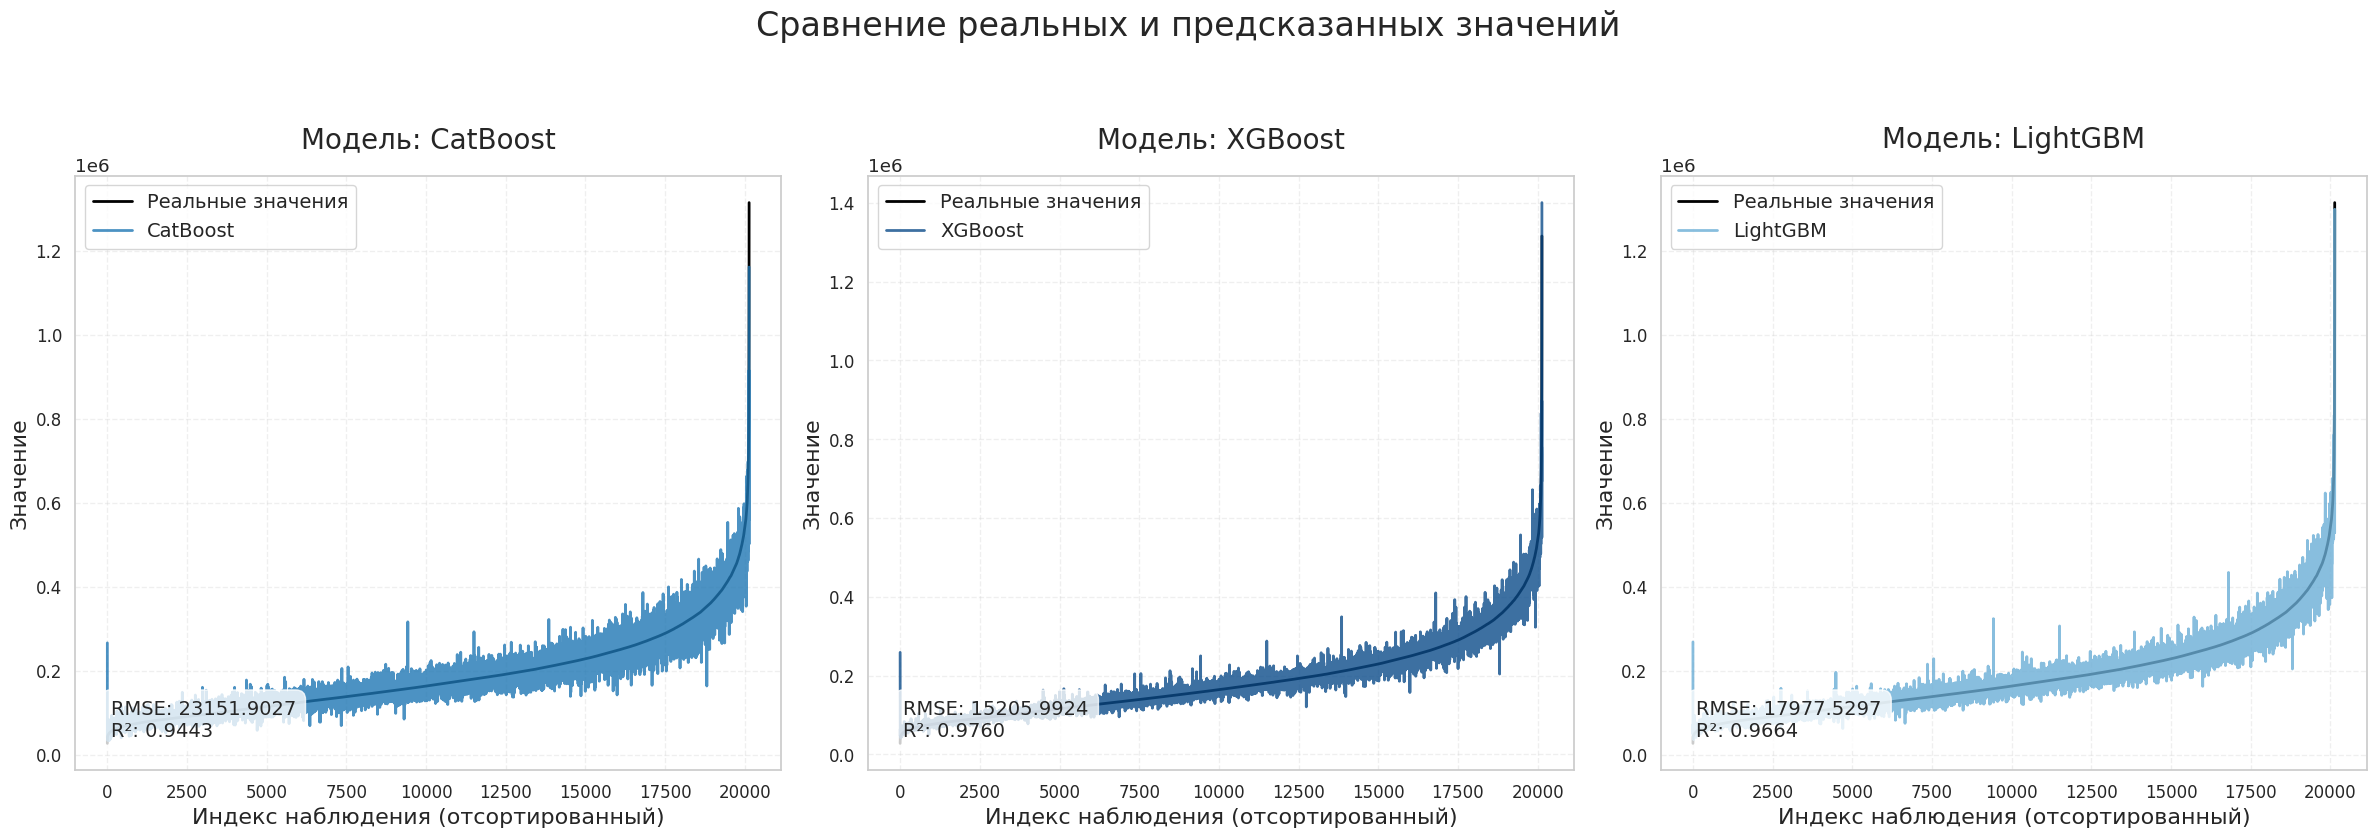

In [17]:
# Голубо-синие оттенки для моделей
catboost_color = '#1f77b4'  # голубой
xgboost_color = '#0c4c8a'   # синий
lightgbm_color = '#6baed6'  # светло-голубой

# Создание отдельных графиков сравнения реальных и предсказанных значений для каждой модели
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Сравнение реальных и предсказанных значений', fontsize=24, y=1.05)

# Сортируем данные по реальным значениям для лучшей визуализации
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
y_pred_catboost_sorted = y_pred_catboost[sorted_indices]
y_pred_xgb_sorted = y_pred_xgb[sorted_indices]
y_pred_lgb_sorted = y_pred_lgb[sorted_indices]

# Выбираем подмножество точек для лучшей визуализации (каждую 10-ю точку)
step = 10

# Список моделей, цветов и предсказаний
models = ['CatBoost', 'XGBoost', 'LightGBM']
colors = [catboost_color, xgboost_color, lightgbm_color]
predictions_sorted = [y_pred_catboost_sorted, y_pred_xgb_sorted, y_pred_lgb_sorted]
rmse_values = [rmse_catboost, rmse_xgb, rmse_lgb]
r2_values = [r2_catboost, r2_xgb, r2_lgb]

# Построение графиков для каждой модели
for i, (model, color, y_pred_sorted, rmse, r2) in enumerate(zip(models, colors, predictions_sorted, rmse_values, r2_values)):
    
    # Построение линий
    axes[i].plot(y_test_sorted[::step], label='Реальные значения', color='black', linewidth=2)
    axes[i].plot(y_pred_sorted[::step], label=model, color=color, linewidth=2, alpha=0.8)
    
    # Настройка осей и легенды
    axes[i].set_xlabel('Индекс наблюдения (отсортированный)', fontsize=16)
    axes[i].set_ylabel('Значение', fontsize=16)
    axes[i].legend(fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.3)
    axes[i].tick_params(labelsize=12)
    
    # Добавление заголовка
    axes[i].set_title(f'Модель: {model}', fontsize=20, pad=20)
    
    # Добавление текстового блока с метриками
    metrics_text = f"RMSE: {rmse:.4f}\nR²: {r2:.4f}"
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    axes[i].text(0.05, 0.05, metrics_text, transform=axes[i].transAxes, fontsize=14, verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


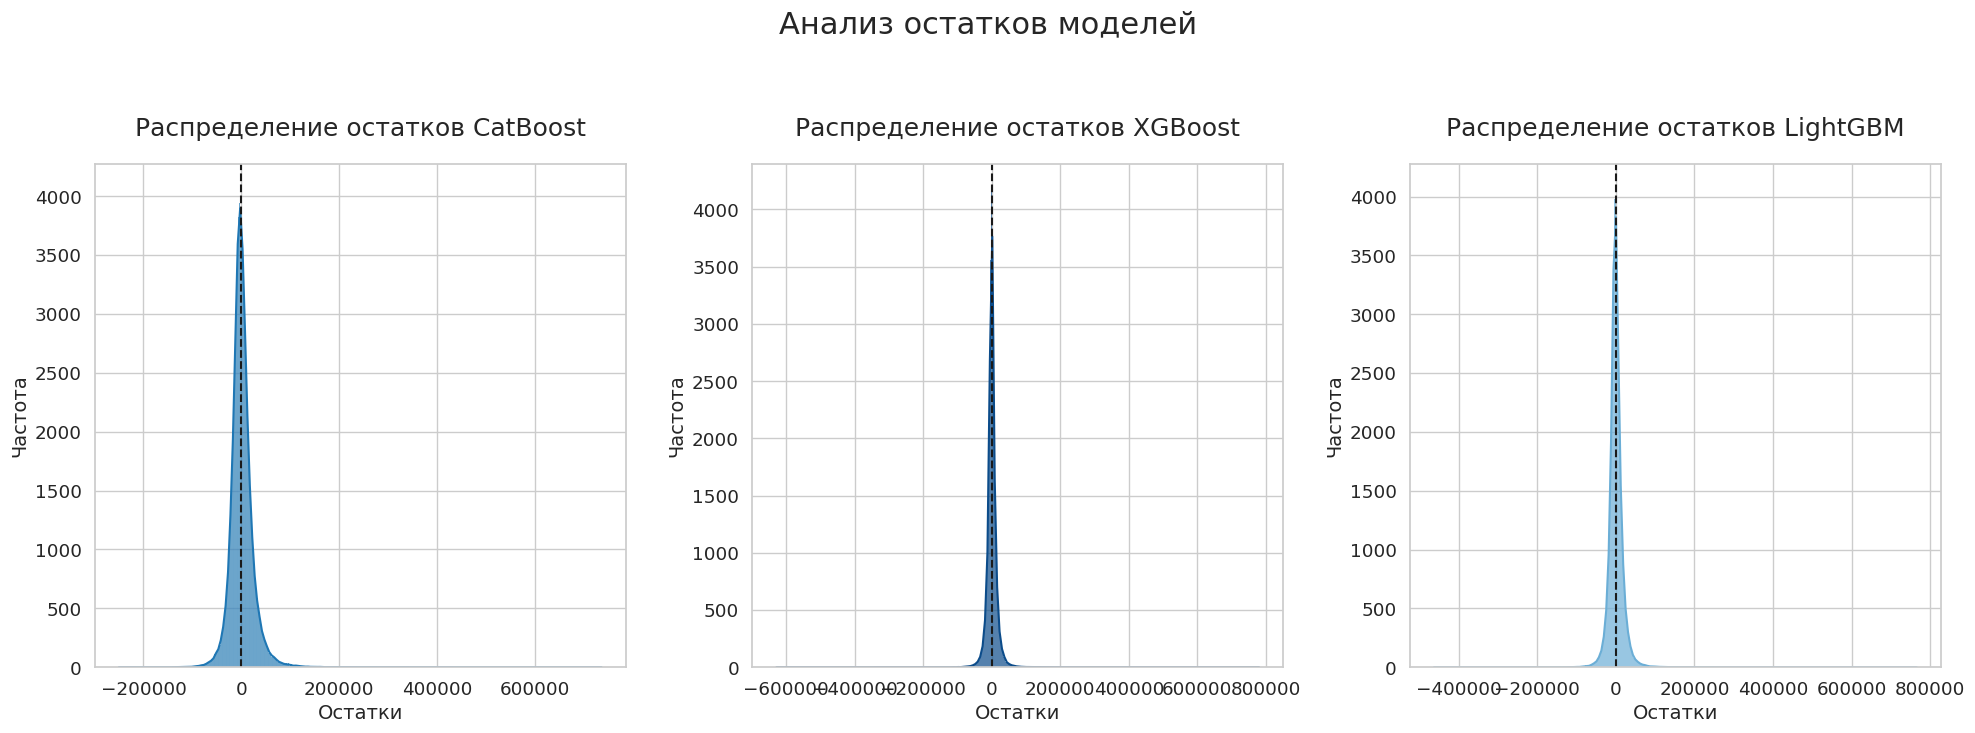

In [18]:
# Создание графика остатков
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Анализ остатков моделей', fontsize=22, y=1.05)

# Расчет остатков
residuals_catboost = y_test - y_pred_catboost
residuals_xgb = y_test - y_pred_xgb
residuals_lgb = y_test - y_pred_lgb

# CatBoost
sns.histplot(residuals_catboost, kde=True, ax=axes[0], color=catboost_color, alpha=0.7)
axes[0].axvline(x=0, color='k', linestyle='--')
axes[0].set_title('Распределение остатков CatBoost', fontsize=18, pad=20)
axes[0].set_xlabel('Остатки', fontsize=14)
axes[0].set_ylabel('Частота', fontsize=14)

# XGBoost
sns.histplot(residuals_xgb, kde=True, ax=axes[1], color=xgboost_color, alpha=0.7)
axes[1].axvline(x=0, color='k', linestyle='--')
axes[1].set_title('Распределение остатков XGBoost', fontsize=18, pad=20)
axes[1].set_xlabel('Остатки', fontsize=14)
axes[1].set_ylabel('Частота', fontsize=14)

# LightGBM
sns.histplot(residuals_lgb, kde=True, ax=axes[2], color=lightgbm_color, alpha=0.7)
axes[2].axvline(x=0, color='k', linestyle='--')
axes[2].set_title('Распределение остатков LightGBM', fontsize=18, pad=20)
axes[2].set_xlabel('Остатки', fontsize=14)
axes[2].set_ylabel('Частота', fontsize=14)

plt.tight_layout()
plt.show()
